In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # adapt plots for retina displays

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

# Load pretrained model and dataset

In [3]:
model = models.alexnet(pretrained=True)

In [4]:
list(model.children())

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
   (1): ReLU(inplace)
   (2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
   (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (4): ReLU(inplace)
   (5): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
   (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (7): ReLU(inplace)
   (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (9): ReLU(inplace)
   (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace)
   (12): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
 ), Sequential(
   (0): Dropout(p=0.5)
   (1): Linear(in_features=9216, out_features=4096, bias=True)
   (2): ReLU(inplace)
   (3): Dropout(p=0.5)
   (4): Linear(in_features=4096, out_features=4096, bias=True)
   (5): ReLU(inplace)
   

In [8]:
valdir = 'data/images'
dataset = datasets.ImageFolder(valdir, transform=transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224)
        ]))

In [9]:
# Transform to apply before feeding the image into the network.

image_means = np.array([0.485, 0.456, 0.406])
image_stds = np.array([0.229, 0.224, 0.225])

input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=image_means, std=image_stds)
])

In [10]:
def get_sample(index):
    """Returns the raw image, the transformed image, and the class."""
    raw_image, class_index = dataset[index]
    raw_image = np.array(raw_image)  # convert from PIL to numpy
    image_tensor = input_transform(raw_image)
    return raw_image, image_tensor, class_index

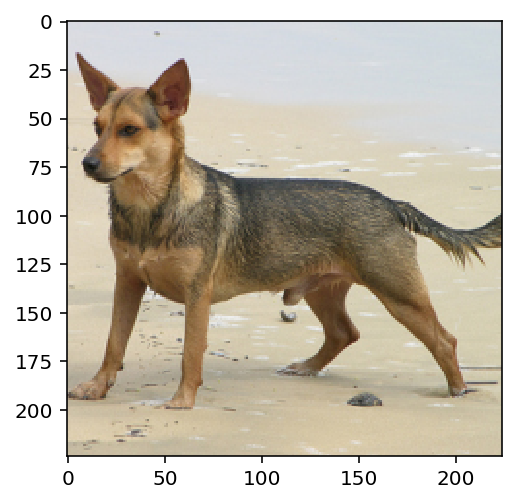

In [11]:
plt.imshow(get_sample(0)[0])

# Interpretation methods

In [12]:
# To get the same results as in pytorch-cnn-visualizations (https://github.com/utkuozbulak/pytorch-cnn-visualizations),
# set a fixed target class and do `postprocess=None`.

def sensitivity_analysis(model, image_tensor, target_class=None, postprocess='abs'):
    # image_tensor can be a pytorch tensor or anything that can be converted to a pytorch tensor (e.g. numpy, list)
    
    image_tensor = torch.Tensor(image_tensor)  # convert numpy or list to tensor
    X = Variable(image_tensor[None], requires_grad=True)  # add dimension to simulate batch
    
    model.eval()
    output = model(X)
    output_class = output.max(1)[1].data.numpy()[0]
    print('Image was classified as:', output_class)
    
    model.zero_grad()
    one_hot_output = torch.zeros(output.size())
    if target_class is None:
        one_hot_output[0, output_class] = 1
    else:
        one_hot_output[0, target_class] = 1
    output.backward(gradient=one_hot_output)
        
    relevance_map = X.grad.data[0].numpy()
    
    if postprocess == 'abs':  # as in Simonyan et al. (2013)
        return np.abs(relevance_map)
    elif postprocess == 'square':  # as in Montavon et al. (2018)
        return relevance_map**2
    elif postprocess is None:
        return relevance_map
    else:
        raise ValueError()
    
def taylor_decomposition(model, image_tensor, target_class=None):
    relevance_map = sensitivity_analysis(model, image_tensor, target_class=target_class)
    
    try:
        image_tensor = image_tensor.numpy()  # if it's a pytorch tensor
    except AttributeError:
        image_tensor = np.asarray(image_tensor)  # if it's a list or anything else
    
    return relevance_map * image_tensor.max(axis=0)  # TODO: How to deal with the several color channels of the image?

In [13]:
def guided_backprop(model, image_tensor, target_class=None, postprocess='abs'):
    
    def relu_hook_function(module, grad_in, grad_out):
        """
        If there is a negative gradient, change it to zero.
        """
        if isinstance(module, nn.ReLU):
            return (torch.clamp(grad_in[0], min=0.0),)
        
    hook_handles = []
    
    try:
        # Loop through layers, hook up ReLUs with relu_hook_function, store handles to hooks.
        for pos, module in model.features._modules.items():
            if isinstance(module, nn.ReLU):
                hook_handle = module.register_backward_hook(relu_hook_function)
                hook_handles.append(hook_handle)

        # Calculate backprop with modified ReLUs.
        relevance_map = sensitivity_analysis(model, image_tensor, target_class=target_class, postprocess=postprocess)
        
    finally:
        # Remove hooks from model.
        # The finally clause re-raises any possible exceptions.
        for hook_handle in hook_handles:
            hook_handle.remove()
            del hook_handle
        
    return relevance_map

In [14]:
from tqdm import tqdm_notebook

In [15]:
def occlusion(model, image_tensor, target_class=None, size=50, stride=25, show_progress=False):
    
    image_tensor = torch.Tensor(image_tensor)  # convert numpy or list to tensor
    X = Variable(image_tensor[None], requires_grad=False)  # add dimension to simulate batch
    
    model.eval()
    
    if target_class is None:
        # Get output without occlusion.
        output = model(X)
        target_class = output.max(1)[1].data.numpy()[0]
        print('Image was classified as:', target_class)
        
    width = image_tensor.shape[1]
    height = image_tensor.shape[2]
    
    xs = range(0, width, stride)
    ys = range(0, height, stride)
    
    relevance_map = np.zeros((len(xs), len(ys)))
    
    # TODO: Change this to normal tqdm when refactoring into a module.
    if show_progress:
        xs = tqdm_notebook(xs, desc='x')
        ys = tqdm_notebook(ys, desc='y', leave=False)
    
    for i_x, x in enumerate(xs):
        x_from = max(x - int(size/2), 0)
        x_to = min(x + int(size/2), width)
        
        for i_y, y in enumerate(ys):
            y_from = max(y - int(size/2), 0)
            y_to = min(y + int(size/2), height)
            
            #print('Occluding from x={} to x={} and y={} to y={}'.format(x_from, x_to, y_from, y_to))
            
            image_tensor_occluded = image_tensor.clone()  # TODO: Check how long this takes.
            image_tensor_occluded[:, x_from:x_to, y_from:y_to] = 0
            
            # TODO: Maybe run this batched.
            output = model(Variable(image_tensor_occluded[None], requires_grad=False))
            #print(output.data[0, target_class])
            relevance_map[i_x, i_y] = output.data[0, target_class]
            
    return relevance_map

# Occlusion patch

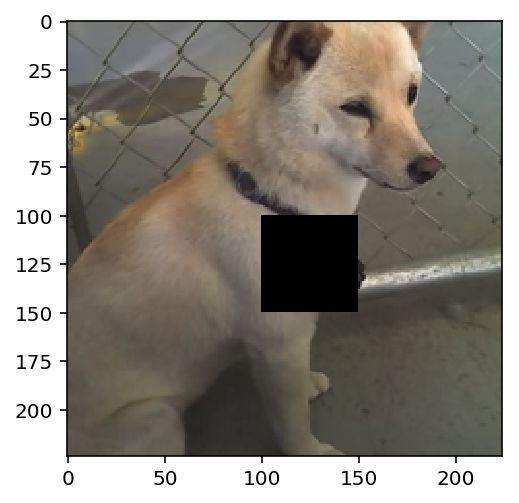

In [16]:
# This is what occlusion looks like.
image, image_tensor, class_index = get_sample(1)
image_occluded = image.copy()
size = 50
image_occluded[100:100+size, 100:100+size] = 0
plt.imshow(image_occluded)

# Compare all methods

Image was classified as: 227
Image was classified as: 227
Image was classified as: 227
Image was classified as: 248
Image was classified as: 248
Image was classified as: 248
Image was classified as: 232
Image was classified as: 232
Image was classified as: 232
Image was classified as: 249
Image was classified as: 249
Image was classified as: 249


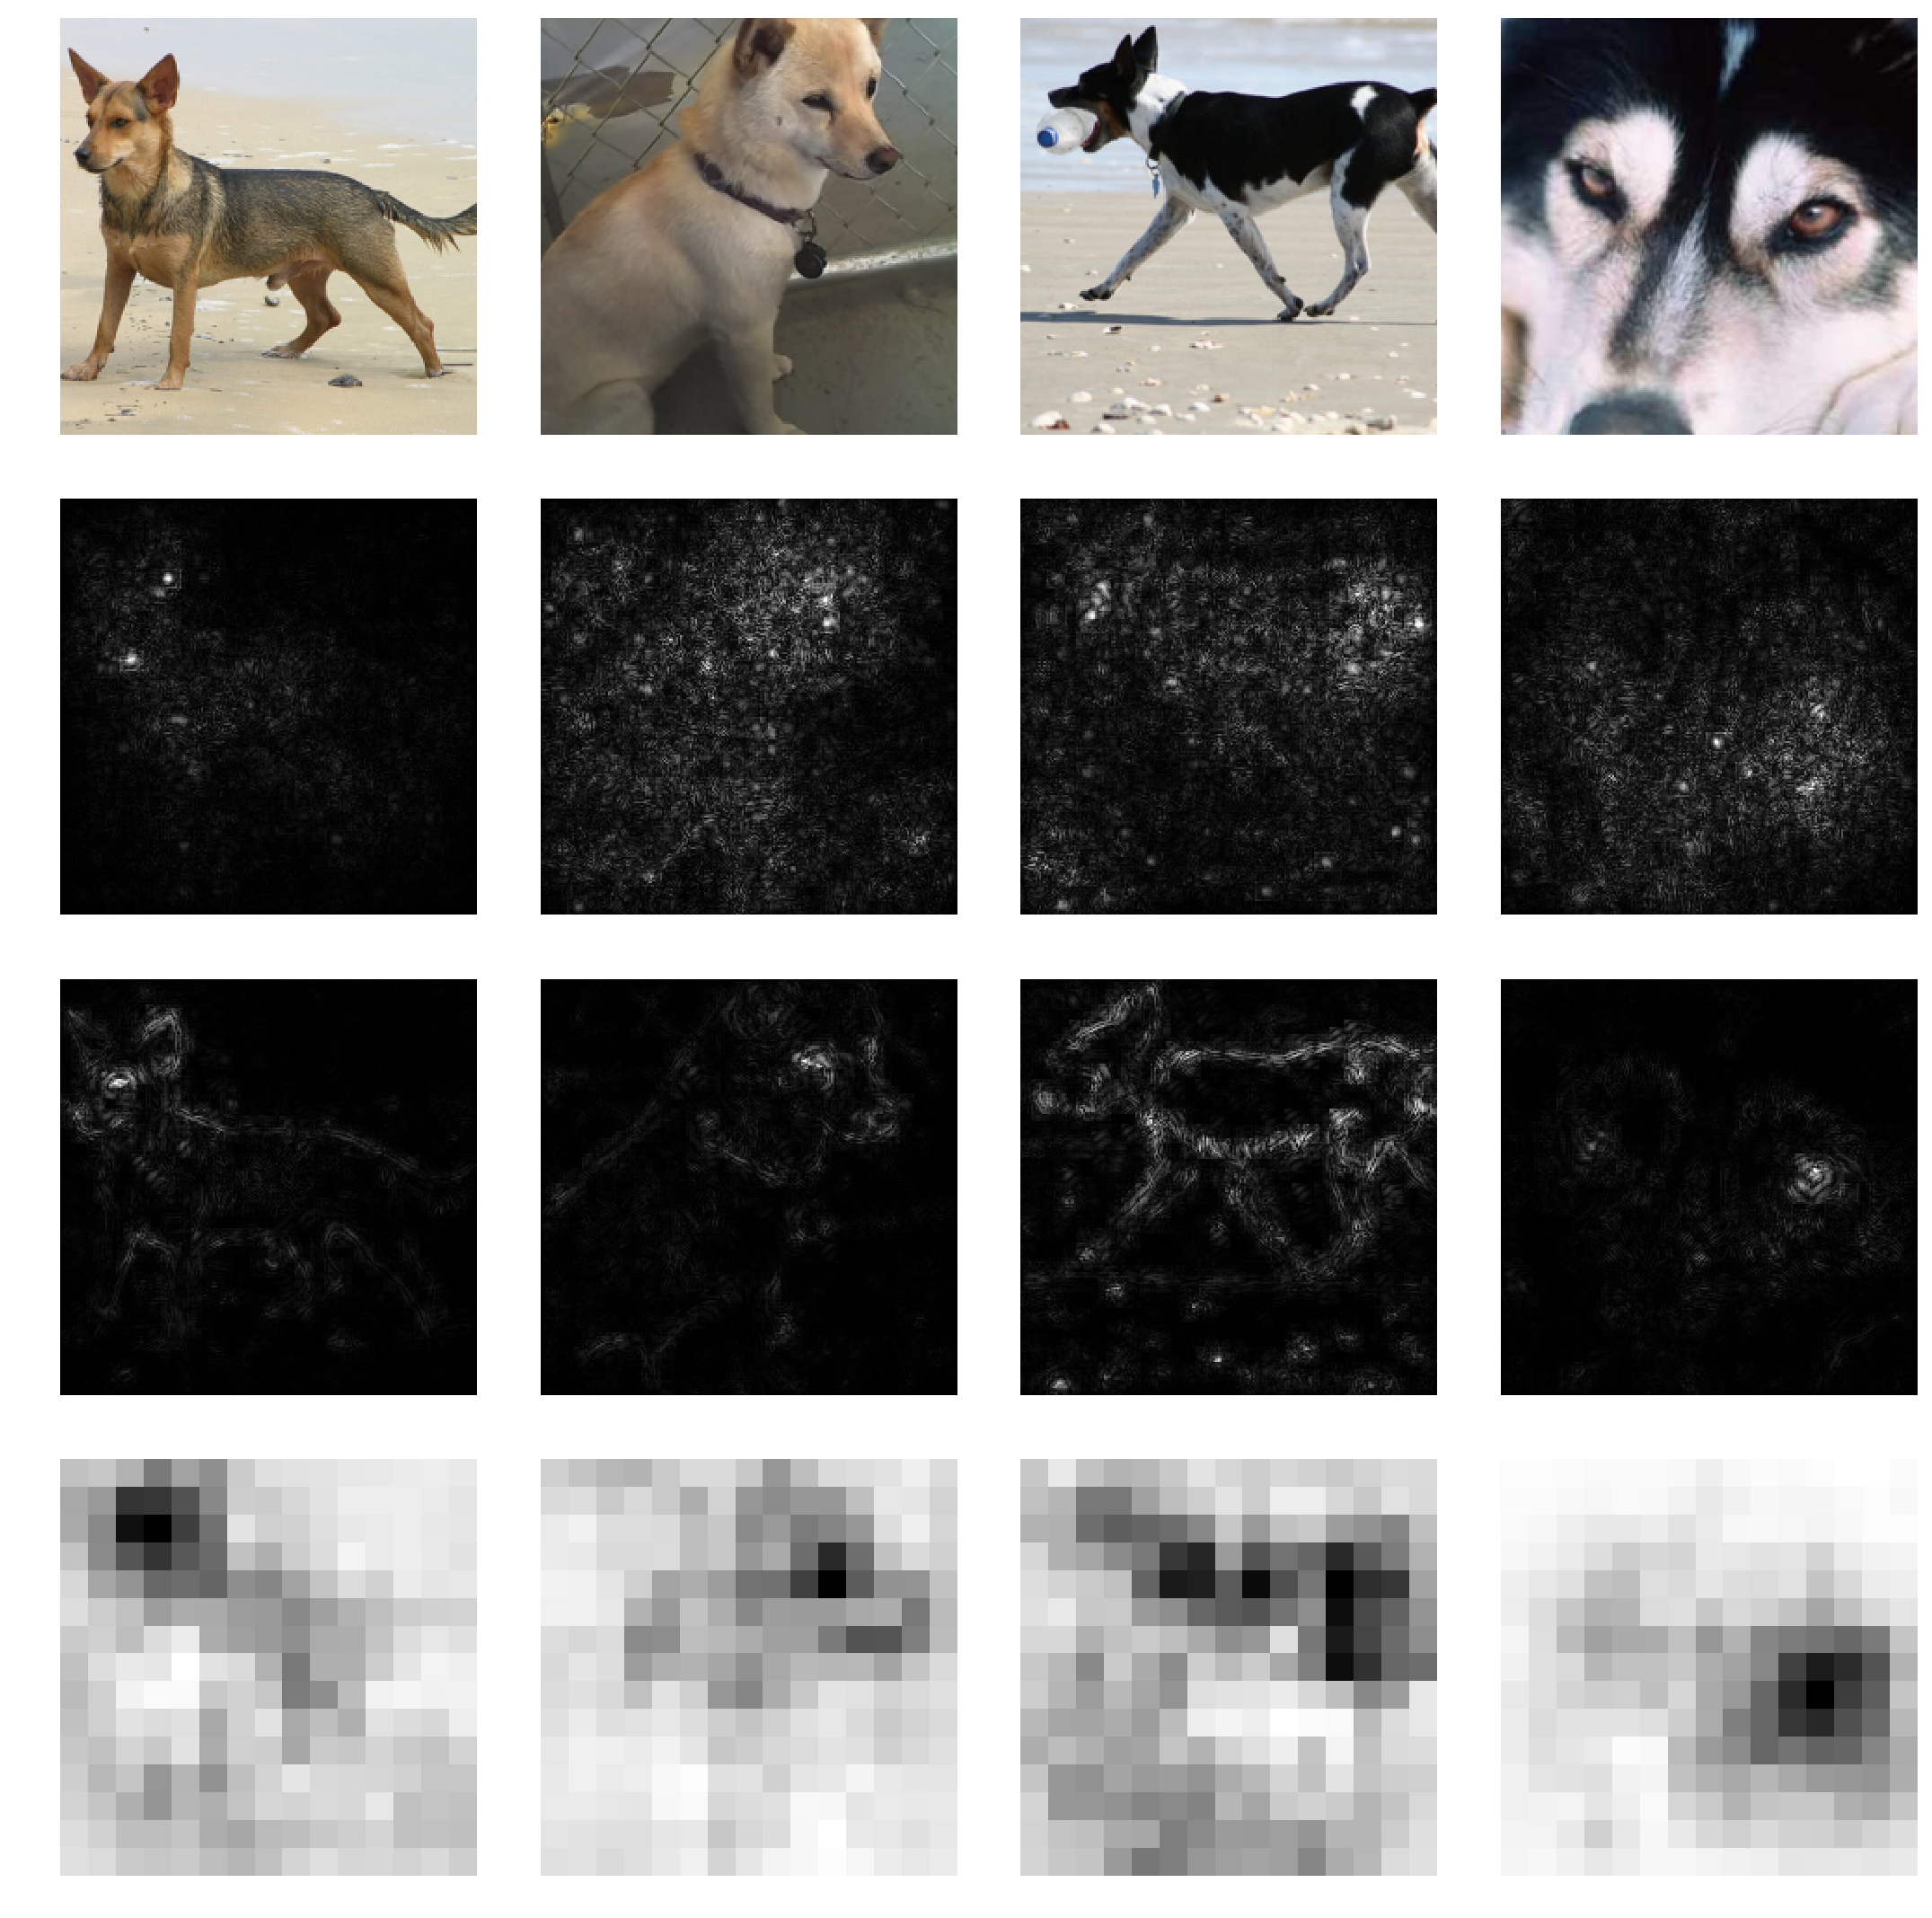

In [19]:
fig, axes = plt.subplots(4, 4, figsize=(15, 15))

offset = 0  # which image in the dataset to start with

for i, vertical_axes in enumerate(axes.T):
    image, image_tensor, class_index = get_sample(i+offset)
    
    plt.sca(vertical_axes[0])
    plt.axis('off')
    plt.imshow(image)
    
    plt.sca(vertical_axes[1])
    plt.axis('off')
    plt.imshow(sensitivity_analysis(model, image_tensor, postprocess='abs').max(0), cmap='Greys_r')
    
    plt.sca(vertical_axes[2])
    plt.axis('off')
    plt.imshow(guided_backprop(model, image_tensor, postprocess='abs').max(0), cmap='Greys_r')
    
    plt.sca(vertical_axes[3])
    plt.axis('off')
    plt.imshow(occlusion(model, image_tensor, size=50, stride=15), cmap='Greys_r')

plt.tight_layout()

- 1st row: Image
- 2nd row: Backprop
- 3rd row: Guided Backprop
- 4th row: Occlusion